# Step1

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from dateutil.relativedelta import relativedelta
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xbg
from catboost import CatBoostClassifier
import catboost as cat
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm import tqdm
import gc
import re
import time
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.4f' % x)

In [162]:
PATH = r'D:\geek growing\Data Competion\DataFountain\2021_Loan_default\datasets'

train_data = pd.read_csv(PATH + r'\train_public.csv')
test_public = pd.read_csv(PATH + r'\test_public.csv')
train_inte = pd.read_csv(PATH + r'\train_internet.csv')

In [163]:
print(len(set(train_inte.user_id).intersection(test_public.user_id))) # train_inte都覆盖了train,test的user_id
print(len(set(train_inte.user_id).intersection(train_data.user_id)))

5000
10000


In [164]:
display("train_data:", train_data.shape)
display(train_data.head())
display("test_public:", test_public.shape)
display(test_public.head())
display("train_inte:", train_inte.shape)
display(train_inte.head())

'train_data:'

(10000, 39)

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,240418,31818.1818,3,11.4660,1174.9100,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193,13,2.4300,0,556.3636,649.0909,3,0,0.0000,7734.2308,91.8000,0,0,1-Dec,5,1,1.0000,0.0000,4.0000,5.0000,4.0000,3,9927,0.0000,0
1,1025197,225197,28000.0000,5,16.8410,670.6900,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491,30,11.0045,1,715.0000,893.7500,3,0,0.0000,31329.0000,54.8000,1,0,Apr-90,40642,1,7.0000,0.0000,4.0000,45.0000,22.0000,0,0,0.0000,0
2,1009360,209360,17272.7273,3,8.9000,603.3200,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459,8,6.4091,0,774.5455,903.6364,5,0,0.0000,18514.0000,57.6923,1,0,Oct-91,154,1,6.0000,0.0000,6.0000,28.0000,19.0000,0,0,0.0000,0
3,1039708,239708,20000.0000,3,4.7880,602.3000,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157,8,9.2045,0,750.0000,875.0000,3,0,0.0000,20707.0000,42.6000,0,0,1-Jun,0,1,5.0000,0.0000,10.0000,15.0000,9.0000,0,0,0.0000,0
4,1027483,227483,15272.7273,3,12.7900,470.3100,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38,21,15.5782,0,609.0909,710.6061,15,0,0.0000,14016.1539,30.4615,0,0,2-May,0,1,10.0000,0.0000,6.0000,15.0000,4.0000,0,0,0.0000,0


'test_public:'

(5000, 38)

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon
0,1000575,200575,2890.9091,3,10.7910,88.0100,B,幼教与中小学校,住宿和餐饮业,5 years,0,1,2017/12/1,0,314,0,23.0400,0,745.0000,869.1667,7,0,0.0000,8647.6923,31.8462,1,0,3-Mar,0,1,2.0000,0.0000,15.0000,5.0000,4.0000,3,773,89.1923
1,1028125,228125,7272.7273,3,9.9900,258.1000,B,普通企业,批发和零售业,10+ years,1,1,2015/7/1,5,29,19,27.7545,0,681.8182,738.6364,24,0,0.0000,9406.1538,18.2769,0,0,Dec-99,6,1,8.0000,0.0000,8.0000,29.0000,14.0000,1,1894,218.5385
2,1010694,210694,26295.4545,3,15.7630,764.0300,C,普通企业,住宿和餐饮业,10+ years,0,2,2013/4/1,0,488,24,25.4945,1,758.1818,947.7273,11,0,0.0000,26414.7692,62.3000,1,0,Apr-99,268,1,6.0000,0.0000,4.0000,10.0000,6.0000,1,5670,1221.2308
3,1026712,226712,22690.9091,5,19.3050,524.3000,D,普通企业,采矿业,10+ years,0,2,2017/12/1,0,489,30,10.6200,0,572.7273,620.4545,8,0,0.0000,1198.0000,7.7000,0,0,Jul-00,0,1,4.0000,0.0000,12.0000,10.0000,8.0000,2,4800,443.0769
4,1002895,202895,14545.4546,3,7.1390,490.3200,A,世界五百强,金融业,1 year,0,0,2016/6/1,2,418,45,6.6109,0,638.1818,691.3636,15,0,0.0000,3920.0000,8.8308,1,0,7-May,5,1,4.0000,0.0000,7.0000,14.0000,9.0000,0,3516,649.1077


'train_inte:'

(750000, 42)

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,sub_class,work_type,employer_type,industry,work_year,house_exist,house_loan_status,censor_status,marriage,offsprings,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,early_return,early_return_amount,early_return_amount_3mon,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,f5,is_default
0,119262,0,12000.0000,5,11.5300,264.1000,B,B5,职员,普通企业,采矿业,NaN,0,0,2,0,0,2015-06-01,0,814.0000,4,5.0700,1.0000,670.0000,674.0000,1.0000,0,0,0.0000,3855.0000,23.1000,0,Mar-1984,0.0000,1.0000,1.0000,0.0000,8.0000,17.0000,8.0000,1.0000,1
1,369815,1,8000.0000,3,13.9800,273.3500,C,C3,其他,普通企业,国际组织,10+ years,0,1,2,1,3,2010-10-01,2,240.0000,21,15.0400,0.0000,725.0000,729.0000,0.0000,0,0,0.0000,118632.0000,99.9000,1,Jan-1992,94.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,0
2,787833,2,20000.0000,5,17.9900,507.7600,D,D2,工人,上市企业,信息传输、软件和信息技术服务业,10+ years,0,0,1,0,0,2016-08-01,0,164.0000,20,17.3800,1.0000,675.0000,679.0000,0.0000,0,0,0.0000,15670.0000,72.5000,0,Oct-1996,0.0000,1.0000,6.0000,0.0000,10.0000,8.0000,3.0000,0.0000,0
3,671675,3,10700.0000,3,10.1600,346.0700,B,B1,职员,普通企业,电力、热力生产供应业,2 years,2,0,2,0,0,2013-05-01,4,48.0000,10,27.8700,0.0000,710.0000,714.0000,0.0000,0,0,0.0000,18859.0000,78.6000,0,Jul-2000,41646.0000,1.0000,3.0000,0.0000,4.0000,11.0000,6.0000,0.0000,0
4,245160,4,8000.0000,3,8.2400,251.5800,B,B1,其他,政府机构,金融业,5 years,1,2,0,0,0,2017-04-01,4,122.0000,9,3.4700,0.0000,660.0000,664.0000,0.0000,0,0,0.0000,8337.0000,67.8000,1,Mar-2000,4.0000,1.0000,3.0000,0.0000,8.0000,6.0000,4.0000,1.0000,0


In [165]:
train_data['work_year'].value_counts()

10+ years    3370
2 years       848
3 years       776
< 1 year      765
1 year        671
5 years       623
4 years       562
6 years       476
8 years       458
7 years       436
9 years       393
Name: work_year, dtype: int64

In [166]:
print(f'There are {train_data.isnull().any().sum()} columns in train dataset with missing values.')

There are 7 columns in train dataset with missing values.


## Models

In [167]:
def train_model_xlc(data_, test_, y_, folds_, model_type='lgb'):
    oof_preds = np.zeros(data_.shape[0])       # 几折合并后的验证集预测label, (oof means out of fold)
    sub_preds = np.zeros(test_.shape[0])        #  测试集预测概率结果
    feature_importance_df = pd.DataFrame()  #  特征重要性数据框
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault']]
    
    if(model_type=='lgb'):   
        for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y_)): 
            trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
            val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]

            clf = LGBMClassifier(
                n_estimators=4000,
                learning_rate=0.08,
                num_leaves=2**5,
                colsample_bytree=0.65,
                subsample=0.9,
                max_depth=5,
                reg_alpha=0.3,
                reg_lambda=0.3,
                min_split_gain=0.01,
                min_child_weight=2,
                silent=-1,
                verbose=-1,
                )

            clf.fit(trn_x, trn_y, 
                    eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                    eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
                   )
            
            oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
            sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))  #  (某一折真实验证集label, 某一折预测验证集label)
           
            del clf, trn_x, trn_y, val_x, val_y   
            gc.collect()    

        print('Full AUC score %.6f' % roc_auc_score(y_, oof_preds))     # (训练集真实label, 几折合并后的验证集预测label)

        test_['isDefault'] = sub_preds # 测试集预测概率结果
    
    
    if(model_type=='xgb'):   
        for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y_)):  
            trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
            val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
    
            clf = XGBClassifier(
                n_estimators=4000,
                learning_rate=0.08,
                objective = 'binary:logistic',
                use_label_encoder=False,
                booster='gbtree',
                colsample_bytree=0.75,
                subsample=0.9,
                max_depth=5,
                reg_alpha=0.3,
                reg_lambda=0.3,
                min_child_weight=2,
                gamma = 0.1,
                )
            
            clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )
            
            oof_preds[val_idx] = clf.predict_proba(val_x)[:, 1]
            sub_preds += clf.predict_proba(test_[feats], )[:, 1] / folds_.n_splits
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            
            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]))) 
            del clf, trn_x, trn_y, val_x, val_y   

            gc.collect() 

        print('Full AUC score %.6f' % roc_auc_score(y_, oof_preds))  
        
        test_['isDefault'] = sub_preds 
    
    if(model_type=='cat'):   
        for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y_)):  
            trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
            val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
    
            clf = CatBoostClassifier(
                iterations=4000,
                learning_rate=0.08,
                num_leaves=2**5,
                subsample=0.9,
                depth=5,
                reg_lambda=0.3,
                silent=True,
                eval_metric='AUC' # catboost的eval_metric是要写在实例化这里的, 不同于xgb, lgb
#                 verbose=-1,
            )

            clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
#                 eval_metric='auc',
                verbose=100, 
                early_stopping_rounds=40  #30
               )
            
            oof_preds[val_idx] = clf.predict_proba(val_x)[:, 1]
            sub_preds += clf.predict_proba(test_[feats])[:, 1] / folds_.n_splits
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))  
            del clf, trn_x, trn_y, val_x, val_y   

            gc.collect()    

        print('Full AUC score %.6f' % roc_auc_score(y_, oof_preds))     

        test_['isDefault'] = sub_preds 
    
    
    return oof_preds, test_[['loan_id', 'isDefault']],  feature_importance_df   #  (几折合并后的验证集预测label, 测试集预测结果，特征重要性数据框)

## Feature Engineer

In [169]:
def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())


def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
                'A': 1,
                'B': 2,
                'C': 3,
                'D': 4,
                'E': 5,
                'F':  6,
                'G': 7,
                }

In [170]:
# 构造时间相关的特征工程
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])

train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])

train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year

In [171]:
cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder   # 标签编码
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    train_inte[col] = lbl.transform(train_inte[col])

In [172]:
# 查看编码issue_date类型数量
print(train_data['issue_date'].nunique())
print(train_inte['issue_date'].nunique())
print(test_public['issue_date'].nunique())

127
139
123


In [173]:
# 按照字典序进行编码
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value)), index=value)).values

In [174]:
se_map = change_object_cols(train_data['issue_date'].append(test_public['issue_date']).append(train_inte['issue_date']).astype(str))
print(se_map)
print(len(se_map))

[112  72  79 ... 102 126  78]
765000


In [175]:
train_data['issue_date'] = se_map[:10000]
test_public['issue_date'] = se_map[10000:15000]
train_inte['issue_date'] = se_map[15000:]

In [176]:
col_to_drop = ['earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1)
train_inte = train_inte.drop(col_to_drop, axis=1)

In [178]:
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

In [179]:
Inte_add_cos

['isDefault', 'known_outstanding_loan', 'app_type', 'known_dero']

In [181]:
display(train_data.head())
train_inteSame.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear,sub_class
0,1040418,240418,31818.1818,3,11.4660,1174.9100,3,3,13,3,0,1,112,2,193,13,2.4300,0,556.3636,649.0909,3,0,0.0000,7734.2308,91.8000,0,0,5,1,1.0000,0.0000,4.0000,5.0000,4.0000,3,9927,0.0000,0,10,5,12,2001,0
1,1025197,225197,28000.0000,5,16.8410,670.6900,3,3,13,10,0,2,72,0,491,30,11.0045,1,715.0000,893.7500,3,0,0.0000,31329.0000,54.8000,1,0,40642,1,7.0000,0.0000,4.0000,45.0000,22.0000,0,0,0.0000,0,6,5,4,1990,2
2,1009360,209360,17272.7273,3,8.9000,603.3200,1,3,3,10,1,0,79,4,459,8,6.4091,0,774.5455,903.6364,5,0,0.0000,18514.0000,57.6923,1,0,154,1,6.0000,0.0000,6.0000,28.0000,19.0000,0,0,0.0000,0,1,2,10,1991,3
3,1039708,239708,20000.0000,3,4.7880,602.3000,1,1,10,6,0,1,97,0,157,8,9.2045,0,750.0000,875.0000,3,0,0.0000,20707.0000,42.6000,0,0,0,1,5.0000,0.0000,10.0000,15.0000,9.0000,0,0,0.0000,0,7,2,6,2001,2
4,1027483,227483,15272.7273,3,12.7900,470.3100,3,3,2,0,2,1,109,0,38,21,15.5782,0,609.0909,710.6061,15,0,0.0000,14016.1539,30.4615,0,0,0,1,10.0000,0.0000,6.0000,15.0000,4.0000,0,0,0.0000,0,7,4,5,2001,3


,employer_type,interest,work_year,early_return,f4,issue_date_dayofweek,region,earliesCreditMon,earliesCreditYear,loan_id,use,issue_date_month,monthly_payment,sub_class,title,user_id,scoring_low,industry,censor_status,f2,post_code,early_return_amount,total_loan,class,house_exist,recircle_b,policy_code,scoring_high,f3,early_return_amount_3mon,debt_loan_ratio,recircle_u,year_of_loan,del_in_18month,issue_date,f0,f1,initial_list_status,pub_dero_bankrup,isDefault,known_outstanding_loan,app_type,known_dero
0,4,11.5300,-1,0,8.0000,0,4,3,1984,119262,0,6,264.1000,9,0.0000,0,670.0000,12,2,8.0000,814.0000,0,12000.0000,2,0,3855.0000,1.0000,674.0000,17.0000,0.0000,5.0700,23.1000,5,1.0000,96,1.0000,0.0000,0,1.0000,NaN,NaN,NaN,NaN
1,4,13.9800,10,0,7.0000,4,21,1,1992,369815,2,10,273.3500,12,94.0000,1,725.0000,6,2,7.0000,240.0000,0,8000.0000,3,0,118632.0000,1.0000,729.0000,13.0000,0.0000,15.0400,99.9000,3,0.0000,40,5.0000,0.0000,1,0.0000,NaN,NaN,NaN,NaN
2,0,17.9900,10,0,3.0000,0,20,10,1996,787833,0,8,507.7600,16,0.0000,2,675.0000,2,1,10.0000,164.0000,0,20000.0000,4,0,15670.0000,1.0000,679.0000,8.0000,0.0000,17.3800,72.5000,5,1.0000,110,6.0000,0.0000,0,0.0000,NaN,NaN,NaN,NaN
3,4,10.1600,2,0,6.0000,2,10,7,2000,671675,4,5,346.0700,5,41646.0000,3,710.0000,11,2,4.0000,48.0000,0,10700.0000,2,2,18859.0000,1.0000,714.0000,11.0000,0.0000,27.8700,78.6000,3,0.0000,71,3.0000,0.0000,0,0.0000,NaN,NaN,NaN,NaN
4,3,8.2400,5,0,4.0000,5,9,3,2000,245160,4,4,251.5800,5,4.0000,4,660.0000,13,0,8.0000,122.0000,0,8000.0000,2,1,8337.0000,1.0000,664.0000,6.0000,0.0000,3.4700,67.8000,3,0.0000,118,3.0000,0.0000,1,0.0000,NaN,NaN,NaN,NaN


## Predict train_inteSame

In [182]:
y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=8828) 

oof_preds, IntePre, importances = train_model_xlc(train_data, train_inteSame, y, folds, model_type='lgb')
IntePre[['loan_id', 'isDefault']].to_csv('sub_lgb0.csv', index=False)
oof_preds, IntePre, importances = train_model_xlc(train_data, train_inteSame, y, folds, model_type='xgb')
IntePre[['loan_id', 'isDefault']].to_csv('sub_xgb0.csv', index=False)
oof_preds, IntePre, importances = train_model_xlc(train_data, train_inteSame, y, folds, model_type='cat')
IntePre[['loan_id', 'isDefault']].to_csv('sub_cat.csv', index=False)

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.965559	training's binary_logloss: 0.198619	valid_1's auc: 0.89404	valid_1's binary_logloss: 0.283442
Early stopping, best iteration is:
[66]	training's auc: 0.952926	training's binary_logloss: 0.219185	valid_1's auc: 0.896603	valid_1's binary_logloss: 0.280178
Fold  1 AUC : 0.896603
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.9666	training's binary_logloss: 0.19903	valid_1's auc: 0.909938	valid_1's binary_logloss: 0.274835
Early stopping, best iteration is:
[77]	training's auc: 0.957663	training's binary_logloss: 0.213092	valid_1's auc: 0.912236	valid_1's binary_logloss: 0.272923
Fold  2 AUC : 0.912236
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[26]	training's auc: 0.930982	training's binary_logloss: 0.266277	valid_1's auc: 0.904931	valid_1's binary_logloss: 0.286485
Fold  3 AUC : 0.904931
Training until valid

In [185]:
sub_lgb = pd.read_csv('sub_lgb0.csv')
sub_xgb = pd.read_csv('sub_xgb0.csv')
sub_cat = pd.read_csv('sub_cat.csv')
sub_df = pd.read_csv('sub_lgb0.csv')
sub_df['isDefault'] = np.nan

In [187]:
%%time
# 几何平均融合
from numpy import math, prod

for i in tqdm(range(sub_lgb.shape[0])):
    base_val = sub_lgb['isDefault'][i] * sub_xgb['isDefault'][i] * sub_cat['isDefault'][i]
    sub_df['isDefault'][i] = math.pow(base_val, 1.0/3)
    
IntePre=sub_df

100%|████████████████████████████████████████████████████████████████████████| 750000/750000 [05:30<00:00, 2268.96it/s]

Wall time: 5min 30s


In [190]:
IntePre['isDef'] = train_inte['is_default'] #  给IntePre增加一列真实label
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'], IntePre.isDefault) 

0.6984653320979745

In [191]:
print(IntePre.shape)
IntePre.head()

(750000, 3)


,loan_id,isDefault,isDef
0,119262,0.3359,1
1,369815,0.1918,0
2,787833,0.6513,0
3,671675,0.3995,0
4,245160,0.2484,0


<AxesSubplot:xlabel='isDefault', ylabel='Density'>

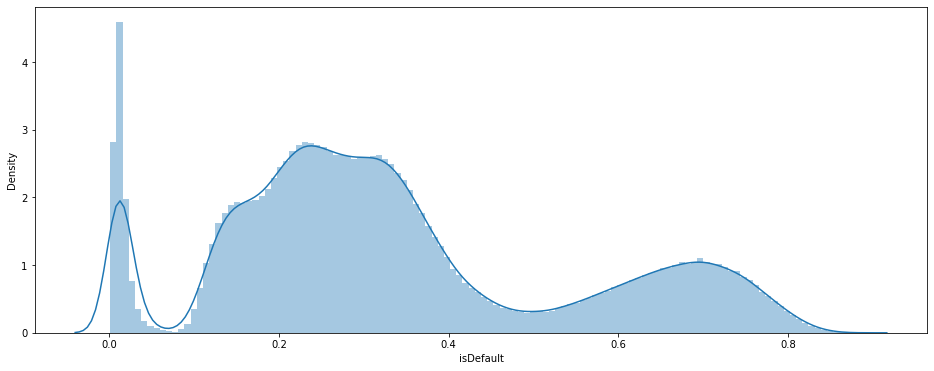

In [192]:
# 查看标签isDefault的分布
plt.figure(figsize=(16, 6))
sns.distplot(IntePre['isDefault'], bins=120, kde=True)

In [195]:
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()
len(InteId)

58787

In [196]:
train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0

train_inteSame['isDefault'] = train_inte['is_default'] # 真实的标签赋值给train_inteSame
use_te = train_inteSame[train_inteSame.loan_id.isin(InteId)].copy() # 把use_te这些行, 逐渐加了进去
data = pd.concat([train_data, test_public, use_te]).reset_index(drop=True)

In [197]:
print(train_data.shape)
print(test_public.shape)
print(use_te.shape)
print(data.shape)

(10000, 44)
(5000, 43)
(58787, 44)
(73787, 44)


In [198]:
print(train_inteSame.shape)
train_inteSame.head()

(750000, 44)


,employer_type,interest,work_year,early_return,f4,issue_date_dayofweek,region,earliesCreditMon,earliesCreditYear,loan_id,use,issue_date_month,monthly_payment,sub_class,title,user_id,scoring_low,industry,censor_status,f2,post_code,early_return_amount,total_loan,class,house_exist,recircle_b,policy_code,scoring_high,f3,early_return_amount_3mon,debt_loan_ratio,recircle_u,year_of_loan,del_in_18month,issue_date,f0,f1,initial_list_status,pub_dero_bankrup,isDefault,known_outstanding_loan,app_type,known_dero,dataSourse
0,4,11.5300,-1,0,8.0000,0,4,3,1984,119262,0,6,264.1000,9,0.0000,0,670.0000,12,2,8.0000,814.0000,0,12000.0000,2,0,3855.0000,1.0000,674.0000,17.0000,0.0000,5.0700,23.1000,5,1.0000,96,1.0000,0.0000,0,1.0000,1,NaN,NaN,NaN,0
1,4,13.9800,10,0,7.0000,4,21,1,1992,369815,2,10,273.3500,12,94.0000,1,725.0000,6,2,7.0000,240.0000,0,8000.0000,3,0,118632.0000,1.0000,729.0000,13.0000,0.0000,15.0400,99.9000,3,0.0000,40,5.0000,0.0000,1,0.0000,0,NaN,NaN,NaN,0
2,0,17.9900,10,0,3.0000,0,20,10,1996,787833,0,8,507.7600,16,0.0000,2,675.0000,2,1,10.0000,164.0000,0,20000.0000,4,0,15670.0000,1.0000,679.0000,8.0000,0.0000,17.3800,72.5000,5,1.0000,110,6.0000,0.0000,0,0.0000,0,NaN,NaN,NaN,0
3,4,10.1600,2,0,6.0000,2,10,7,2000,671675,4,5,346.0700,5,41646.0000,3,710.0000,11,2,4.0000,48.0000,0,10700.0000,2,2,18859.0000,1.0000,714.0000,11.0000,0.0000,27.8700,78.6000,3,0.0000,71,3.0000,0.0000,0,0.0000,0,NaN,NaN,NaN,0
4,3,8.2400,5,0,4.0000,5,9,3,2000,245160,4,4,251.5800,5,4.0000,4,660.0000,13,0,8.0000,122.0000,0,8000.0000,2,1,8337.0000,1.0000,664.0000,6.0000,0.0000,3.4700,67.8000,3,0.0000,118,3.0000,0.0000,1,0.0000,0,NaN,NaN,NaN,0


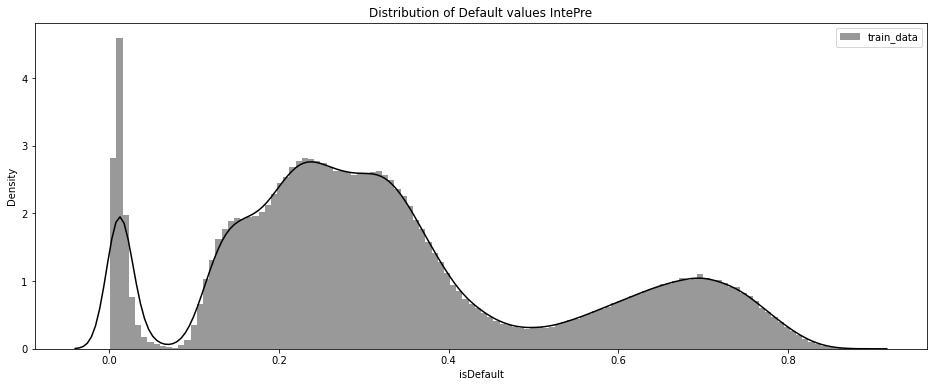

In [199]:
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True, bins=120, label='train_data')
plt.legend();plt.show()

In [200]:
train = data[data['isDefault'].notna()] # train = train_data + use_te
test  = data[data['isDefault'].isna()]   # test = test_public

In [203]:
display(train.shape)
display(test.shape)

(68787, 44)

(5000, 44)

## Predict test

In [204]:
y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=8828)
oof_preds, test_preds, importances = train_model_xlc(train, test, y, folds, model_type='lgb')
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('nn2.csv', index=False) # train_public + train_internet_sample -> test_public

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[46]	training's auc: 0.991906	training's binary_logloss: 0.0360168	valid_1's auc: 0.988155	valid_1's binary_logloss: 0.0418891
Fold  1 AUC : 0.988155
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.994545	training's binary_logloss: 0.0313392	valid_1's auc: 0.987326	valid_1's binary_logloss: 0.041563
Early stopping, best iteration is:
[82]	training's auc: 0.993511	training's binary_logloss: 0.0330263	valid_1's auc: 0.987462	valid_1's binary_logloss: 0.0414311
Fold  2 AUC : 0.987462
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[47]	training's auc: 0.991736	training's binary_logloss: 0.0362125	valid_1's auc: 0.988698	valid_1's binary_logloss: 0.0397456
Fold  3 AUC : 0.988698
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.994892	training's binary_logloss: 0.0304843	valid_

# Step 2

In [205]:
PATH = r'D:\geek growing\Data Competion\DataFountain\2021_Loan_default\datasets'

train_data = pd.read_csv(PATH + r'\train_public.csv')
test_data = pd.read_csv(PATH + r'\test_public.csv')
sub=pd.read_csv("nn2.csv")  # nn2.csv 是上一轮train_data+use_te(从train_inter中按0.05选出的样本) 训练 lgb
                                               # 之后在test_public上预测出的结果

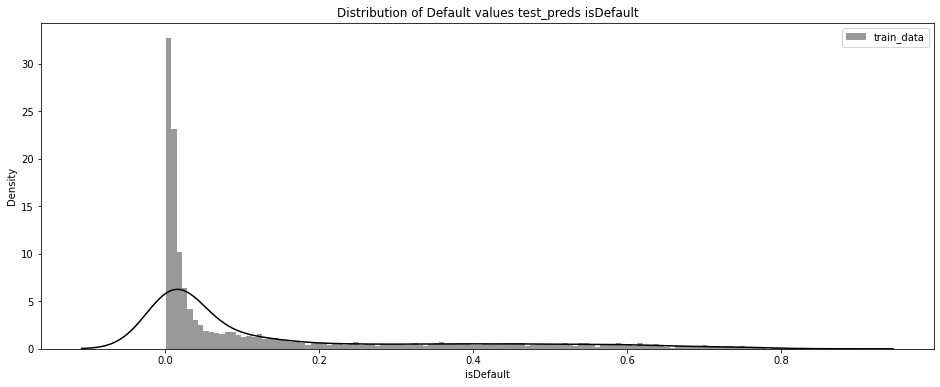

In [206]:
# 查看测试集test_preds预测标签isDefault的分布
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values test_preds isDefault")
sns.distplot(sub['isDefault'],color="black", kde=True, bins=120, label='train_data')
plt.legend();plt.show()

In [208]:
# psudo-label
sub=sub.rename(columns={'id': 'loan_id'})
sub.loc[sub['isDefault']<0.3,'isDefault'] = 0 # < 0.3的, 人为将他设置为0
nw_sub=sub[(sub['isDefault']==0)]
len(nw_sub)

3999

In [209]:
nw_sub

,loan_id,isDefault
0,1000575,0.0000
1,1028125,0.0000
2,1010694,0.0000
3,1026712,0.0000
4,1002895,0.0000
...,...,...
4994,1032099,0.0000
4996,1016651,0.0000
4997,1024140,0.0000
4998,1014316,0.0000


In [210]:
print(len(set(nw_sub['loan_id']).intersection(test_data['loan_id'])))
print(test_data.shape)
print(nw_sub.shape)

3999

In [212]:
test_data.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon
0,1000575,200575,2890.9091,3,10.7910,88.0100,B,幼教与中小学校,住宿和餐饮业,5 years,0,1,2017/12/1,0,314,0,23.0400,0,745.0000,869.1667,7,0,0.0000,8647.6923,31.8462,1,0,3-Mar,0,1,2.0000,0.0000,15.0000,5.0000,4.0000,3,773,89.1923
1,1028125,228125,7272.7273,3,9.9900,258.1000,B,普通企业,批发和零售业,10+ years,1,1,2015/7/1,5,29,19,27.7545,0,681.8182,738.6364,24,0,0.0000,9406.1538,18.2769,0,0,Dec-99,6,1,8.0000,0.0000,8.0000,29.0000,14.0000,1,1894,218.5385
2,1010694,210694,26295.4545,3,15.7630,764.0300,C,普通企业,住宿和餐饮业,10+ years,0,2,2013/4/1,0,488,24,25.4945,1,758.1818,947.7273,11,0,0.0000,26414.7692,62.3000,1,0,Apr-99,268,1,6.0000,0.0000,4.0000,10.0000,6.0000,1,5670,1221.2308
3,1026712,226712,22690.9091,5,19.3050,524.3000,D,普通企业,采矿业,10+ years,0,2,2017/12/1,0,489,30,10.6200,0,572.7273,620.4545,8,0,0.0000,1198.0000,7.7000,0,0,Jul-00,0,1,4.0000,0.0000,12.0000,10.0000,8.0000,2,4800,443.0769
4,1002895,202895,14545.4546,3,7.1390,490.3200,A,世界五百强,金融业,1 year,0,0,2016/6/1,2,418,45,6.6109,0,638.1818,691.3636,15,0,0.0000,3920.0000,8.8308,1,0,7-May,5,1,4.0000,0.0000,7.0000,14.0000,9.0000,0,3516,649.1077


In [213]:
nw_test_data=test_data.merge(nw_sub,on='loan_id',how='inner')  
nw_train_data = pd.concat([train_data,nw_test_data]).reset_index(drop=True)  # 采用伪标签
nw_train_data.to_csv("nw_train_public.csv",index=0)
nw_test_data.shape

(3999, 39)

# step3

In [749]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold
from dateutil.relativedelta import relativedelta
from lightgbm import LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.4f' % x)

In [750]:
PATH = r'D:\geek growing\Data Competion\DataFountain\2021_Loan_default\datasets'

train_data = pd.read_csv('nw_train_public.csv') 
test_public = pd.read_csv(PATH + r'\test_public.csv')
train_inte = pd.read_csv(PATH + r'\train_internet.csv')
submit_example = pd.read_csv(PATH + r'\submit_example.csv')

In [751]:
display(train_data.shape) # 10000(train) + 3828(test)
display(test_public.shape)
display(train_inte.shape)

(13999, 39)

(5000, 38)

(750000, 42)

In [752]:
def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'

class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

In [753]:
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])

#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据
train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year


In [754]:
cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    train_inte[col] = lbl.transform(train_inte[col])

In [755]:
# 按照字典序进行编码
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value)), index=value)).values

In [756]:
print(train_data['issue_date'].nunique())
print(train_inte['issue_date'].nunique())
print(test_public['issue_date'].nunique())

130
139
123


In [757]:
se_map = change_object_cols(train_data['issue_date'].append(test_public['issue_date']).append(train_inte['issue_date']).astype(str))
print(se_map)
print(len(se_map))

[112  72  79 ... 102 126  78]
768999


In [758]:
train_data['issue_date'] = se_map[:train_data.shape[0]]
test_public['issue_date'] = se_map[train_data.shape[0]:train_data.shape[0]+5000]
train_inte['issue_date'] = se_map[train_data.shape[0]+5000:]

In [759]:
col_to_drop = ['earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1)
train_inte = train_inte.drop(col_to_drop, axis=1)

In [760]:
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

In [761]:
display(Inte_add_cos)
display(train_data.head())
display(test_data.head())

['isDefault', 'known_outstanding_loan', 'app_type', 'known_dero']

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear
0,1040418,240418,31818.1818,3,11.4660,1174.9100,3,3,13,3,0,1,112,2,193,13,2.4300,0,556.3636,649.0909,3,0,0.0000,7734.2308,91.8000,0,0,5,1,1.0000,0.0000,4.0000,5.0000,4.0000,3,9927,0.0000,0.0000,10,5,12,2001
1,1025197,225197,28000.0000,5,16.8410,670.6900,3,3,13,10,0,2,72,0,491,30,11.0045,1,715.0000,893.7500,3,0,0.0000,31329.0000,54.8000,1,0,40642,1,7.0000,0.0000,4.0000,45.0000,22.0000,0,0,0.0000,0.0000,6,5,4,1990
2,1009360,209360,17272.7273,3,8.9000,603.3200,1,3,3,10,1,0,79,4,459,8,6.4091,0,774.5455,903.6364,5,0,0.0000,18514.0000,57.6923,1,0,154,1,6.0000,0.0000,6.0000,28.0000,19.0000,0,0,0.0000,0.0000,1,2,10,1991
3,1039708,239708,20000.0000,3,4.7880,602.3000,1,1,10,6,0,1,97,0,157,8,9.2045,0,750.0000,875.0000,3,0,0.0000,20707.0000,42.6000,0,0,0,1,5.0000,0.0000,10.0000,15.0000,9.0000,0,0,0.0000,0.0000,7,2,6,2001
4,1027483,227483,15272.7273,3,12.7900,470.3100,3,3,2,0,2,1,109,0,38,21,15.5782,0,609.0909,710.6061,15,0,0.0000,14016.1539,30.4615,0,0,0,1,10.0000,0.0000,6.0000,15.0000,4.0000,0,0,0.0000,0.0000,7,4,5,2001


,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear,dataSourse
13999,1000575,200575,2890.9091,3,10.7910,88.0100,2,2,1,5,0,1,126,0,314.0000,0,23.0400,0.0000,745.0000,869.1667,7.0000,0.0000,0.0000,8647.6923,31.8462,1,0.0000,0.0000,1.0000,2.0000,0.0000,15.0000,5.0000,4.0000,3,773,89.1923,NaN,12,4,3,2001,1
14000,1028125,228125,7272.7273,3,9.9900,258.1000,2,4,9,10,1,1,97,5,29.0000,19,27.7545,0.0000,681.8182,738.6364,24.0000,0.0000,0.0000,9406.1538,18.2769,0,0.0000,6.0000,1.0000,8.0000,0.0000,8.0000,29.0000,14.0000,1,1894,218.5385,NaN,7,2,12,1999,1
14001,1010694,210694,26295.4545,3,15.7630,764.0300,3,4,1,10,0,2,70,0,488.0000,24,25.4945,1.0000,758.1818,947.7273,11.0000,0.0000,0.0000,26414.7692,62.3000,1,0.0000,268.0000,1.0000,6.0000,0.0000,4.0000,10.0000,6.0000,1,5670,1221.2308,NaN,4,0,4,1999,1
14002,1026712,226712,22690.9091,5,19.3050,524.3000,4,4,12,10,0,2,126,0,489.0000,30,10.6200,0.0000,572.7273,620.4545,8.0000,0.0000,0.0000,1198.0000,7.7000,0,0.0000,0.0000,1.0000,4.0000,0.0000,12.0000,10.0000,8.0000,2,4800,443.0769,NaN,12,4,7,2000,1
14003,1002895,202895,14545.4546,3,7.1390,490.3200,1,1,13,1,0,0,108,2,418.0000,45,6.6109,0.0000,638.1818,691.3636,15.0000,0.0000,0.0000,3920.0000,8.8308,1,0.0000,5.0000,1.0000,4.0000,0.0000,7.0000,14.0000,9.0000,0,3516,649.1077,NaN,6,2,5,2001,1


In [762]:
y = train_data['isDefault']
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8828)  # 546789

oof_preds, IntePre, importances = train_model_xlc(train_data, train_inteSame, y, folds, model_type='lgb')
IntePre[['loan_id', 'isDefault']].to_csv('sub_lgb0.csv', index=False)
oof_preds, IntePre, importances = train_model_xlc(train_data, train_inteSame, y, folds, model_type='xgb')
IntePre[['loan_id', 'isDefault']].to_csv('sub_xgb0.csv', index=False)
oof_preds, IntePre, importances = train_model_xlc(train_data, train_inteSame, y, folds, model_type='cat')
IntePre[['loan_id', 'isDefault']].to_csv('sub_cat.csv', index=False)

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[48]	training's auc: 0.944145	training's binary_logloss: 0.195284	valid_1's auc: 0.908135	valid_1's binary_logloss: 0.230023
Fold  1 AUC : 0.908135
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[55]	training's auc: 0.946939	training's binary_logloss: 0.192773	valid_1's auc: 0.91675	valid_1's binary_logloss: 0.221378
Fold  2 AUC : 0.916750
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[56]	training's auc: 0.950185	training's binary_logloss: 0.18751	valid_1's auc: 0.898889	valid_1's binary_logloss: 0.232345
Fold  3 AUC : 0.898889
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[54]	training's auc: 0.943824	training's binary_logloss: 0.19482	valid_1's auc: 0.908483	valid_1's binary_logloss: 0.227544
Fold  4 AUC : 0.908483
Training until validation s

In [763]:
sub_lgb = pd.read_csv('sub_lgb0.csv')
sub_xgb = pd.read_csv('sub_xgb0.csv')
sub_cat = pd.read_csv('sub_cat.csv')
sub_df = pd.read_csv('sub_lgb0.csv')
sub_df['isDefault'] = np.nan

In [662]:
%%time
# 几何平均融合
from numpy import math, prod
for i in tqdm(range(sub_lgb.shape[0])):
    base_val = sub_lgb['isDefault'][i] * sub_xgb['isDefault'][i] * sub_cat['isDefault'][i]
    sub_df['isDefault'][i] = math.pow(base_val, 1.0/3)
IntePre=sub_df

In [764]:
IntePre.to_csv('IntePre.csv', index=False)
IntePre = pd.read_csv('IntePre.csv')
IntePre

,loan_id,isDefault
0,119262,0.2679
1,369815,0.2906
2,787833,0.4460
3,671675,0.2994
4,245160,0.1784
...,...,...
749995,624287,0.2582
749996,427602,0.0081
749997,206828,0.3903
749998,293912,0.2846


In [771]:
IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'], IntePre.isDefault) 

0.7353750752805439

In [772]:
IntePre.sort_values(by='isDefault', ascending=False, inplace=False)

,loan_id,isDefault,isDef
388842,50251,0.8256,1
200437,382923,0.8179,0
390221,182433,0.8162,1
427827,398261,0.8067,1
521056,151986,0.8024,1
...,...,...,...
711758,764979,0.0013,0
640377,585590,0.0013,0
589534,788102,0.0012,0
445268,99826,0.0011,0


In [773]:
## 选择阈值0.05，从internet表中提取预测小于该概率的样本, 并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()
print(len(InteId))

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0

train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([train_data, test_public, use_te]).reset_index(drop=True)

59355


In [776]:
display(train_data.shape) # train = 10000(train) + (3828)test
display(test_public.shape)
display(use_te.shape)
roc_auc_score(IntePre['isDef'], IntePre.isDefault)

(13999, 43)

(5000, 42)

(59355, 43)

0.7353750752805439

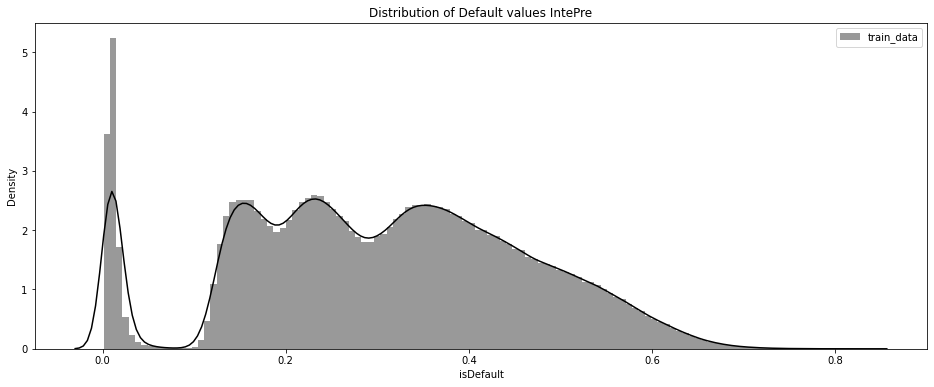

In [777]:
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
plt.legend(); plt.show()

In [779]:
train = data[data['isDefault'].notna()]
test = data[data['isDefault'].isna()]

display(train.shape)  # train = 13828(train) + 59915(use_te)
display(test.shape)   # test = 5000

(73354, 43)

(5000, 43)

<AxesSubplot:>

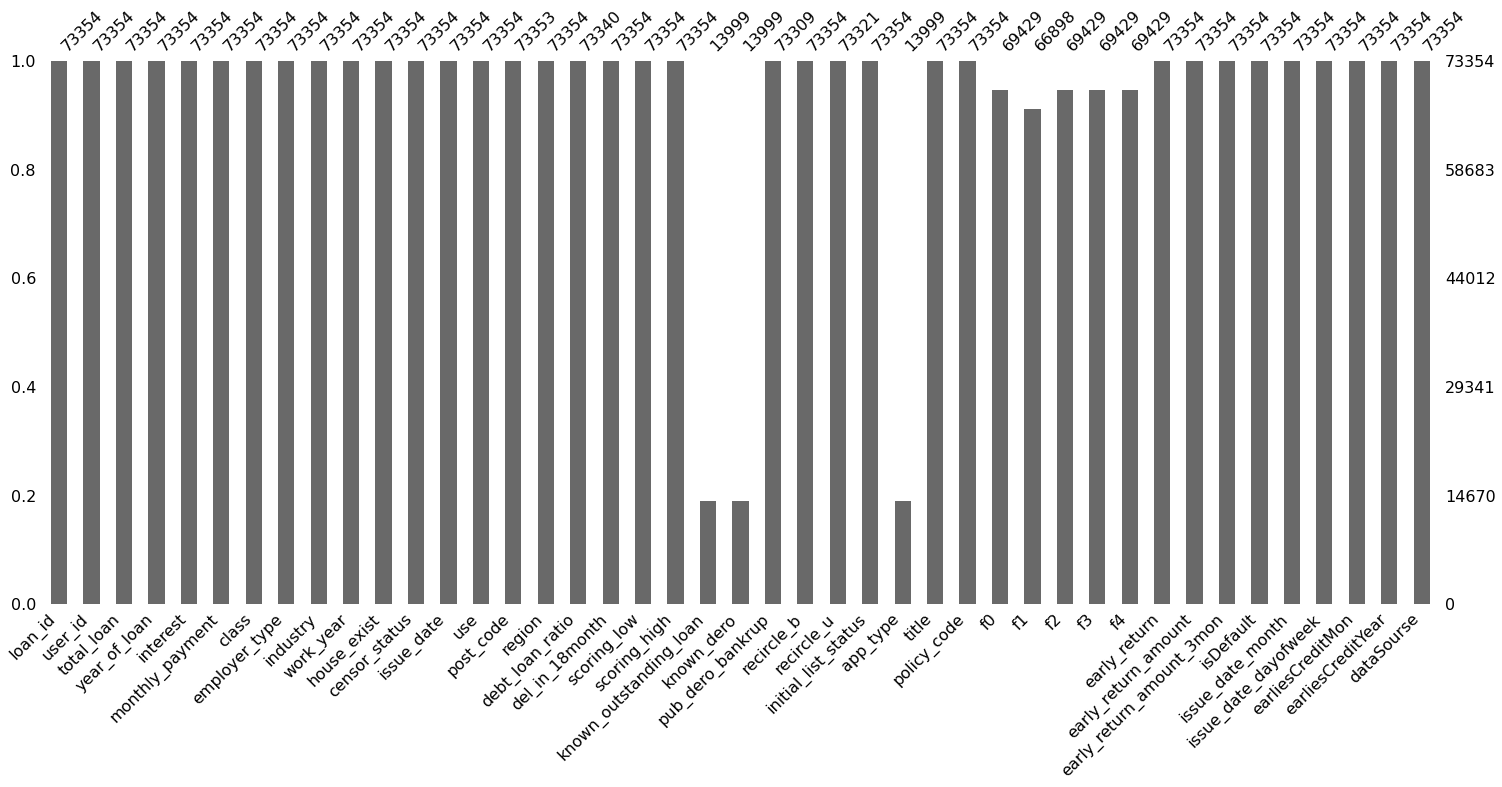

In [780]:
msno.bar(train)

<AxesSubplot:>

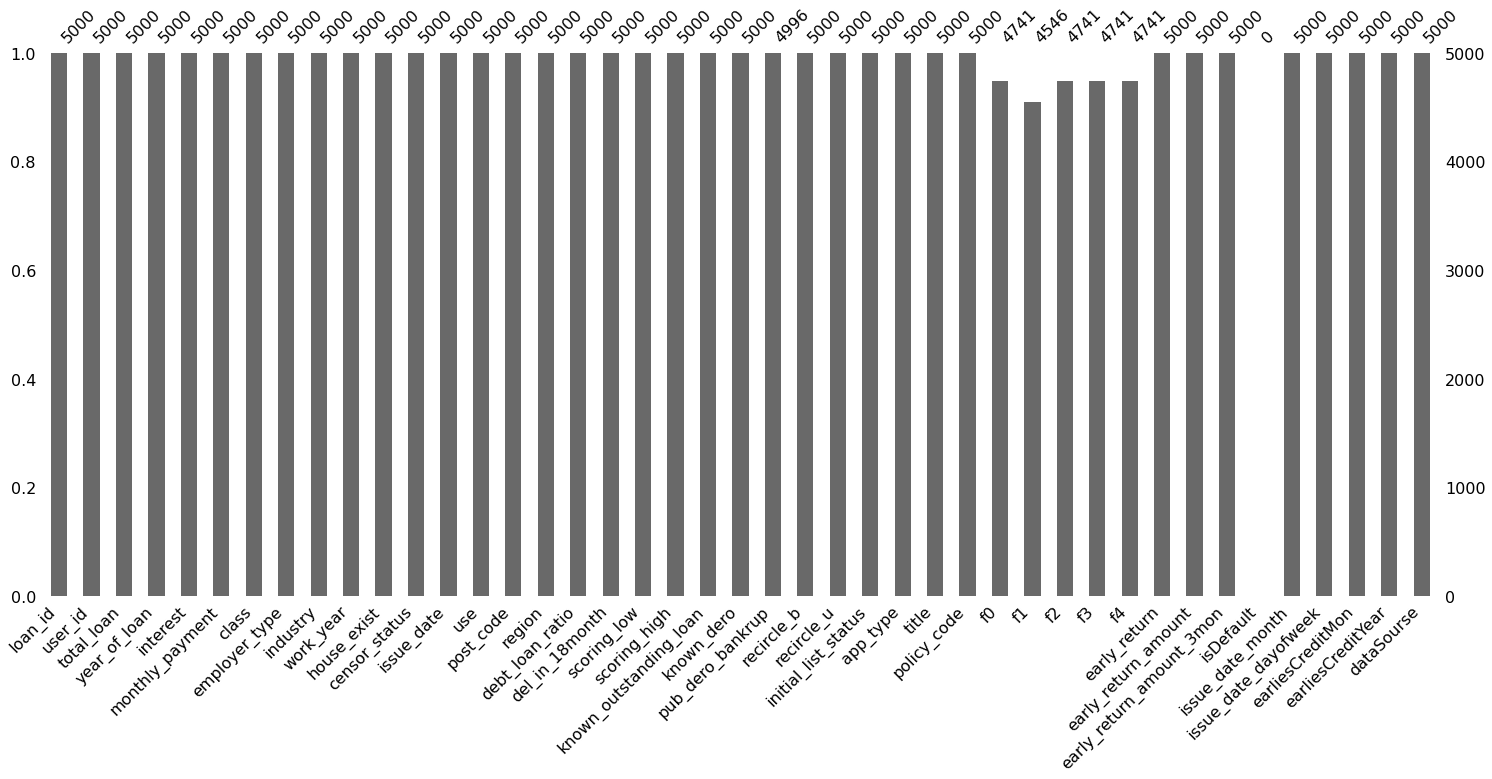

In [781]:
msno.bar(test)

In [785]:
del train['app_type']
del test['app_type']
del train['policy_code']
del test['policy_code']
del test['isDefault']

In [786]:
# 缺失值填充
loss_numerical_feas = ['known_outstanding_loan', 'known_dero', 'debt_loan_ratio', 'pub_dero_bankrup', 'recircle_u', ]
f_feas = ['f0', 'f1', 'f2', 'f3', 'f4']

# train_forclass
train[loss_numerical_feas] = train[loss_numerical_feas].fillna(train[loss_numerical_feas].median())  # 中位数填充
train[f_feas] = train[f_feas].fillna(train[f_feas].median()) # # 中位数填充
train['post_code'] = train['post_code'].fillna(train['post_code'].mode()[0])  # 众数填充
    
# test_forclass
test[loss_numerical_feas] = test[loss_numerical_feas].fillna(test[loss_numerical_feas].median())  # 中位数填充
test[f_feas] = test[f_feas].fillna(test[f_feas].median())

In [787]:
### 如有必要，根据train_inte的sub_class特征分布特点，对train_data, test_public进行K-means聚类。以充分吸取train_inte的信息；
print(train_inte['sub_class'].unique())
print(train['class'].unique())
print(test['class'].unique())
'''
['A1' 'A2' 'A3' 'A4' 'A5'
'B1' 'B2' 'B3' 'B4' 'B5' 
'C1' 'C2' 'C3' 'C4' 'C5' 
'D1' 'D2' 'D3' 'D4' 'D5'
'E1' 'E2' 'E3' 'E4' 'E5' 
'F1' 'F2' 'F3' 'F4' 'F5'
'G1' 'G2' 'G3' 'G4' 'G5']

共七大类其中每大类中有五小类，采用聚类方案
'''

def feature_Kmeans(data, label):
    mms = MinMaxScaler()  # 因为要计算距离, 所以需要消除量纲之间的影响
    feats = [f for f in data.columns if f not in ['loan_id', 'user_id', 'isDefault']] 
    data = data[feats]
    mmsModel = mms.fit_transform(data.loc[data['class'] == label])
    clf = KMeans(5, random_state=2021)
    pre = clf.fit(mmsModel)
    test = pre.labels_
    final_data = pd.Series(test, index=data.loc[data['class'] == label].index)
    if label == 1: # label=1被分成了5个类
        final_data = final_data.map({0: 'A1', 1: 'A2', 2: 'A3', 3: 'A4', 4: 'A5'})
    elif label == 2:
        final_data = final_data.map({0: 'B1', 1: 'B2', 2: 'B3', 3: 'B4', 4: 'B5'})
    elif label == 3:
        final_data = final_data.map({0: 'C1', 1: 'C2', 2: 'C3', 3: 'C4', 4: 'C5'})
    elif label == 4:
        final_data = final_data.map({0: 'D1', 1: 'D2', 2: 'D3', 3: 'D4', 4: 'D5'})
    elif label == 5:
        final_data = final_data.map({0: 'E1', 1: 'E2', 2: 'E3', 3: 'E4', 4: 'E5'})
    elif label == 6:
        final_data = final_data.map({0: 'F1', 1: 'F2', 2: 'F3', 3: 'F4', 4: 'F5'})
    elif label == 7:
        final_data = final_data.map({0: 'G1', 1: 'G2', 2: 'G3', 3: 'G4', 4: 'G5'})
    return final_data

['B5' 'C3' 'D2' 'B1' 'C5' 'A5' 'C1' 'B4' 'A1' 'D1' 'C4' 'E2' 'C2' 'D4'
 'E3' 'D3' 'A4' 'B3' 'A3' 'E5' 'B2' 'G5' 'A2' 'F3' 'D5' 'E1' 'F4' 'F1'
 'F5' 'F2' 'G1' 'E4' 'G2' 'G3' 'G4']
[3 1 2 4 5 6 7]
[2 3 4 1 5 6 7]


In [788]:
# 训练集合并
train_data1 = feature_Kmeans(train, 1)
train_data2 = feature_Kmeans(train, 2)
train_data3 = feature_Kmeans(train, 3)
train_data4 = feature_Kmeans(train, 4)
train_data5 = feature_Kmeans(train, 5)
train_data6 = feature_Kmeans(train, 6)
train_data7 = feature_Kmeans(train, 7)
train_dataall = pd.concat( [train_data1, train_data2, train_data3, train_data4, train_data5, train_data6, train_data7]).reset_index(drop=True)
train['sub_class'] = train_dataall # train中新增了列特征sub_class


# 测试集test_public合并
test_data1 = feature_Kmeans(test, 1)
test_data2 = feature_Kmeans(test, 2)
test_data3 = feature_Kmeans(test, 3)
test_data4 = feature_Kmeans(test, 4)
test_data5 = feature_Kmeans(test, 5)
test_data6 = feature_Kmeans(test, 6)
test_data7 = feature_Kmeans(test, 7)
test_dataall = pd.concat([test_data1, test_data2, test_data3, test_data4, test_data5, test_data6, test_data7], axis=0).reset_index(drop=True)
test['sub_class'] = test_dataall #  test_data中新增了列特征sub_class


cat_cols = ['sub_class']
for col in cat_cols:
    lbl = LabelEncoder().fit(train[col])
    train[col] = lbl.transform(train[col])
    test[col] = lbl.transform(test[col])

In [559]:
# # 构造其他特征, 如有必要
# train['post_code_interst_mean'] = train.groupby(['post_code'])['interest'].transform('mean')
# test['post_code_interst_mean'] = test.groupby(['post_code'])['interest'].transform('mean')

# train['industry_mean_interest'] = train.groupby(['industry'])['interest'].transform('mean')
# test['industry_mean_interest'] = test.groupby(['industry'])['interest'].transform('mean')

# train['recircle_u_b_std'] = train.groupby(['recircle_u'])['recircle_b'].transform('std')
# test['recircle_u_b_std'] = test.groupby(['recircle_u'])['recircle_b'].transform('std')


# train['early_return_amount_early_return'] = train['early_return_amount'] / train_data['early_return'] # 提前还款累计金额/提前还款次数
# test['early_return_amount_early_return'] = test['early_return_amount'] / test_public['early_return']

# # 可能出现极大值和空值
# train['early_return_amount_early_return'][np.isinf(train['early_return_amount_early_return'])] = 0 # 把不合理的异常值置为0
# test['early_return_amount_early_return'][np.isinf(test['early_return_amount_early_return'])] = 0

# # 还款利息
# train['total_loan_monthly_payment'] = train['monthly_payment'] * train['year_of_loan'] * 12 - train['total_loan']
# test['total_loan_monthly_payment'] = test['monthly_payment'] * test['year_of_loan'] * 12 - test['total_loan']

## Predict test

In [791]:
y = train['isDefault']
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8828) # 546789

oof_preds, test_preds, importances = train_model_xlc(train, test, y, folds, model_type='lgb')
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('sub_lgb.csv', index=False) # 0.98355

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[18]	training's auc: 0.987794	training's binary_logloss: 0.0460563	valid_1's auc: 0.986385	valid_1's binary_logloss: 0.0476095
Fold  1 AUC : 0.986385
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[19]	training's auc: 0.988727	training's binary_logloss: 0.0444312	valid_1's auc: 0.985051	valid_1's binary_logloss: 0.0483233
Fold  2 AUC : 0.985051
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[59]	training's auc: 0.991075	training's binary_logloss: 0.0357878	valid_1's auc: 0.983625	valid_1's binary_logloss: 0.0447907
Fold  3 AUC : 0.983625
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.992277	training's binary_logloss: 0.0339417	valid_1's auc: 0.985984	valid_1's binary_logloss: 0.0415363
Early stopping, best iteration is:
[75]	training's auc: 0.990937	training

In [792]:
oof_preds, test_preds, importances = train_model_xlc(train, test, y, folds, model_type='xgb')
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('sub_xgb.csv', index=False) # 0.983380

[0]	validation_0-auc:0.97880	validation_1-auc:0.98233
[81]	validation_0-auc:0.99111	validation_1-auc:0.98703
Fold  1 AUC : 0.987346
[0]	validation_0-auc:0.97601	validation_1-auc:0.97411
[96]	validation_0-auc:0.99205	validation_1-auc:0.98494
Fold  2 AUC : 0.985159
[0]	validation_0-auc:0.98112	validation_1-auc:0.97321
[100]	validation_0-auc:0.99281	validation_1-auc:0.98347
[120]	validation_0-auc:0.99370	validation_1-auc:0.98335
Fold  3 AUC : 0.983685
[0]	validation_0-auc:0.97932	validation_1-auc:0.97808
[100]	validation_0-auc:0.99240	validation_1-auc:0.98625
[119]	validation_0-auc:0.99331	validation_1-auc:0.98621
Fold  4 AUC : 0.986441
[0]	validation_0-auc:0.98088	validation_1-auc:0.97361
[100]	validation_0-auc:0.99218	validation_1-auc:0.98454
[114]	validation_0-auc:0.99285	validation_1-auc:0.98455
Fold  5 AUC : 0.984830
Full AUC score 0.983540


In [793]:
oof_preds, test_preds, importances = train_model_xlc(train, test, y, folds, model_type='cat')
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('sub_cat.csv', index=False) # 0.984070

0:	test: 0.9743701	test1: 0.9764486	best: 0.9764486 (0)	total: 15.6ms	remaining: 1m 2s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.9863882107
bestIteration = 53

Shrink model to first 54 iterations.
Fold  1 AUC : 0.986388
0:	test: 0.9746842	test1: 0.9750771	best: 0.9750771 (0)	total: 31.7ms	remaining: 2m 6s
100:	test: 0.9894433	test1: 0.9845958	best: 0.9845958 (100)	total: 1.37s	remaining: 52.9s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.9847887139
bestIteration = 159

Shrink model to first 160 iterations.
Fold  2 AUC : 0.984789
0:	test: 0.9753384	test1: 0.9724447	best: 0.9724447 (0)	total: 16ms	remaining: 1m 4s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.9828680248
bestIteration = 48

Shrink model to first 49 iterations.
Fold  3 AUC : 0.982868
0:	test: 0.9744642	test1: 0.9760420	best: 0.9760420 (0)	total: 12.5ms	remaining: 49.9s
100:	test: 0.9891765	test1: 0.9856265	best: 0.9856946 (76)	total: 1.36s	remaining: 52

# lgb/xgb/cat 加权融合

In [794]:
sub_lgb = pd.read_csv(r'sub_lgb.csv')
sub_xgb = pd.read_csv(r'sub_xgb.csv')
sub_cat = pd.read_csv(r'sub_cat.csv')
sub_df = pd.read_csv(PATH + r'\submit_example.csv')
sub_df['isDefault'] = np.nan

In [795]:
%%time
# 几何平均融合
from numpy import math, prod
for i in range(sub_lgb.shape[0]):
    base_val = sub_lgb['isDefault'][i] * sub_xgb['isDefault'][i] * sub_cat['isDefault'][i]
    sub_df['isDefault'][i] = math.pow(base_val, 1.0/3)

Wall time: 1.09 s


In [796]:
sub_df

,id,isDefault
0,1000575,0.0041
1,1028125,0.0094
2,1010694,0.0036
3,1026712,0.0034
4,1002895,0.0071
...,...,...
4995,1008856,0.1951
4996,1016651,0.0041
4997,1024140,0.0038
4998,1014316,0.0038


In [150]:
# 保存结果
from datetime import datetime

seed = 8828
time_now = datetime.now()
time_now = time_now.strftime('%Y%m%d_%H%M')
res_name = 'mysub_' + time_now + f'_seed{seed}' + '.csv'
res_name
path = r'D:\geek growing\Data Competion\DataFountain\2021_Loan_default\sub_version\data'

res = sub_df.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']]
res.to_csv(path + '\\' + res_name, index=False)